In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import explode


In [2]:
'''
Data Exploration and Model Comparison

This notebook supports the development and optimization of the ALS model by
analyzing user and item distributions and visualizing model performance across
hyperparameters.

It supports the proposal by contributing to:
- Data preprocessing and understanding data sparsity.
- Performance evaluation and optimization of ALS parameters.
'''

spark = SparkSession.builder.appName("RecommenderSystem").getOrCreate()

# Load ratings and movies
ratings = spark.read.csv("data/ratings.csv", header=True, inferSchema=True)
movies = spark.read.csv("data/movies.csv", header=True, inferSchema=True)

# Train-test split
(training, test) = ratings.randomSplit([0.8, 0.2], seed=42)

/tmp/ipykernel_902/3847091446.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ratings_pd, x="rating", palette="viridis")


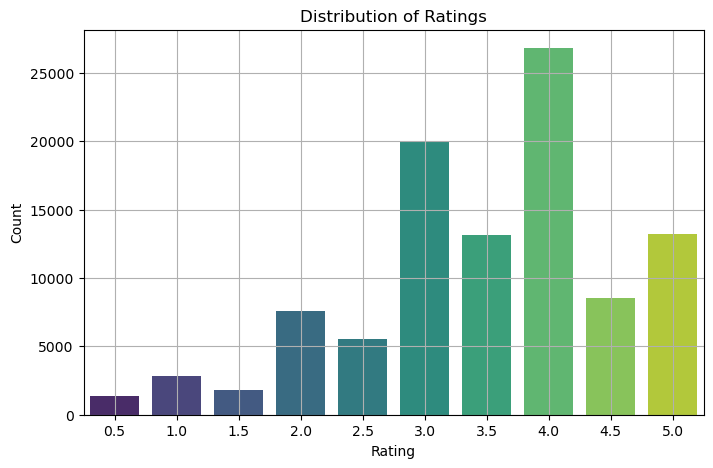

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

'''
Visualize Ratings Distribution
These plots help assess data quality and sparsity for collaborative filtering.
'''

# Convert Spark DataFrame to Pandas for visualization
ratings_pd = ratings.toPandas()

# Plot the distribution of ratings
plt.figure(figsize=(8, 5))
sns.countplot(data=ratings_pd, x="rating", palette="viridis")
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(True)
plt.show()


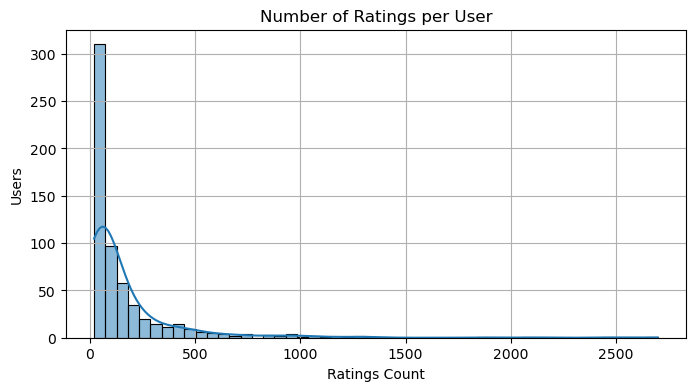

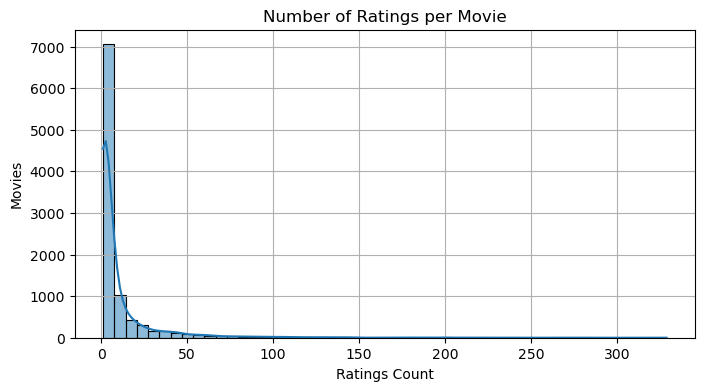

In [4]:
# Ratings per user
user_counts = ratings_pd['userId'].value_counts()
plt.figure(figsize=(8, 4))
sns.histplot(user_counts, bins=50, kde=True)
plt.title("Number of Ratings per User")
plt.xlabel("Ratings Count")
plt.ylabel("Users")
plt.grid(True)
plt.show()

# Ratings per movie
movie_counts = ratings_pd['movieId'].value_counts()
plt.figure(figsize=(8, 4))
sns.histplot(movie_counts, bins=50, kde=True)
plt.title("Number of Ratings per Movie")
plt.xlabel("Ratings Count")
plt.ylabel("Movies")
plt.grid(True)
plt.show()


In [5]:
'''
Grid Search for ALS Hyperparameters
Explore combinations of rank and regularization (regParam) to optimize model
'''

ranks = [5, 10, 15]
regParams = [0.05, 0.1, 0.2]
results = []

for rank in ranks:
    for reg in regParams:
        als = ALS(
            userCol="userId",
            itemCol="movieId",
            ratingCol="rating",
            nonnegative=True,
            implicitPrefs=False,
            coldStartStrategy="drop",
            rank=rank,
            maxIter=10,
            regParam=reg
        )
        model = als.fit(training)
        predictions = model.transform(test)

        evaluator = RegressionEvaluator(
            metricName="rmse",
            labelCol="rating",
            predictionCol="prediction"
        )
        rmse = evaluator.evaluate(predictions)
        results.append((rank, reg, rmse))
        print(f"Rank={rank}, RegParam={reg}, RMSE={rmse:.4f}")


Rank=5, RegParam=0.05, RMSE=0.9071
Rank=5, RegParam=0.1, RMSE=0.8795
Rank=5, RegParam=0.2, RMSE=0.8791
Rank=10, RegParam=0.05, RMSE=0.9250
Rank=10, RegParam=0.1, RMSE=0.8775
Rank=10, RegParam=0.2, RMSE=0.8767
Rank=15, RegParam=0.05, RMSE=0.9232
Rank=15, RegParam=0.1, RMSE=0.8719
Rank=15, RegParam=0.2, RMSE=0.8772


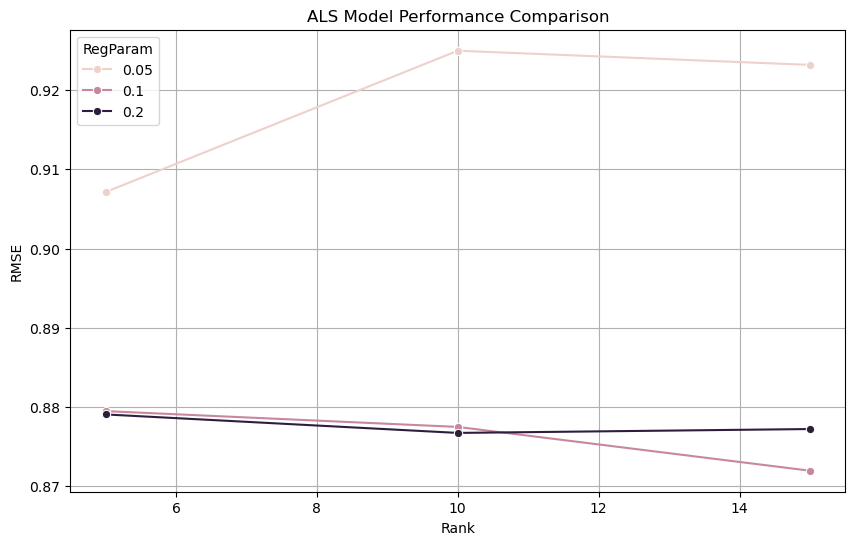

In [6]:
'''
Plot Performance
Use line plot to compare RMSE across ALS configurations.
'''

results_df = pd.DataFrame(results, columns=["Rank", "RegParam", "RMSE"])

plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x="Rank", y="RMSE", hue="RegParam", marker="o")
plt.title("ALS Model Performance Comparison")
plt.xlabel("Rank")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()


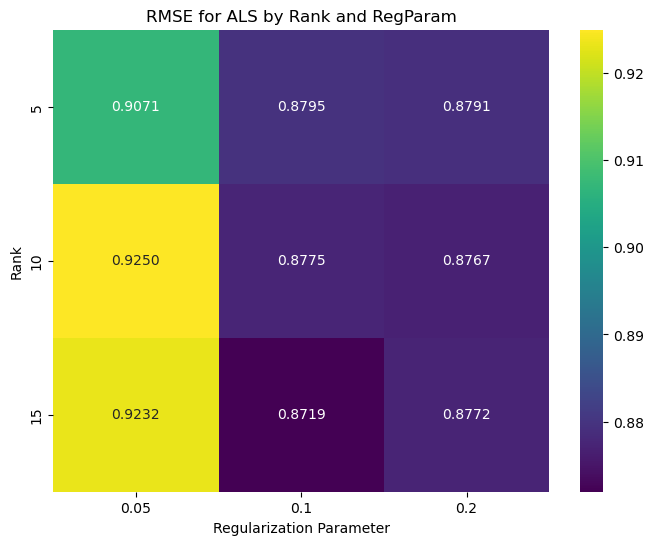

In [7]:
# Convert results to DataFrame
df_results = pd.DataFrame(results, columns=["rank", "regParam", "rmse"])

# Pivot table for heatmap
heatmap_data = df_results.pivot(index="rank", columns="regParam", values="rmse")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="viridis")
plt.title("RMSE for ALS by Rank and RegParam")
plt.ylabel("Rank")
plt.xlabel("Regularization Parameter")
plt.show()

/tmp/ipykernel_902/2238918439.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_movies_pd, x="count", y="title", palette="magma")


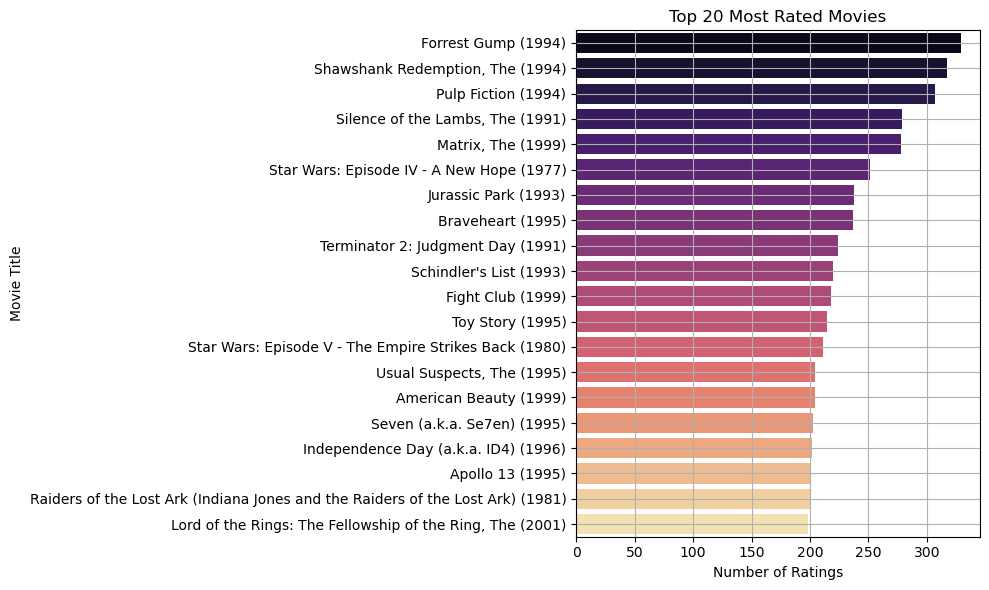

In [8]:
'''
Top N Most Rated Movies
'''

# Join ratings with movie titles
ratings_with_titles = ratings.join(movies, on="movieId", how="inner")
movie_counts = ratings_with_titles.groupBy("title").count().orderBy("count", ascending=False)

# Convert to Pandas for plotting
top_movies_pd = movie_counts.limit(20).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_movies_pd, x="count", y="title", palette="magma")
plt.title("Top 20 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.grid(True)
plt.tight_layout()
plt.show()


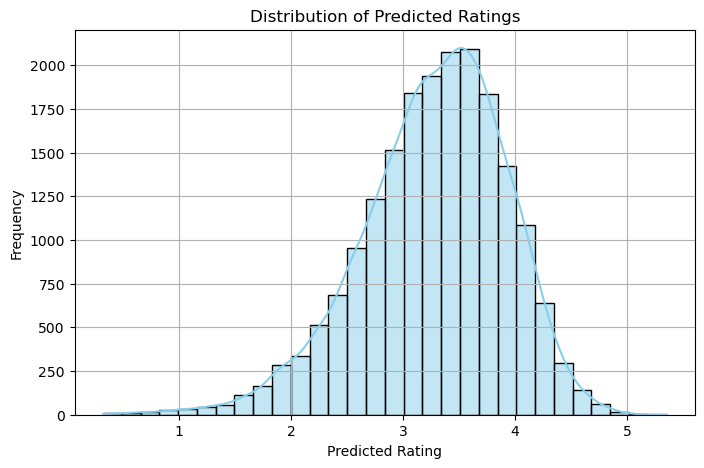

In [9]:
'''
Histogram of Predicted Ratings
'''
predictions_pd = predictions.select("prediction").dropna().toPandas()

plt.figure(figsize=(8, 5))
sns.histplot(predictions_pd["prediction"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Predicted Ratings")
plt.xlabel("Predicted Rating")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


/tmp/ipykernel_902/1575872025.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=user_recs_pd, x="rating", y="title", palette="viridis")
/tmp/ipykernel_902/1575872025.py:35: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


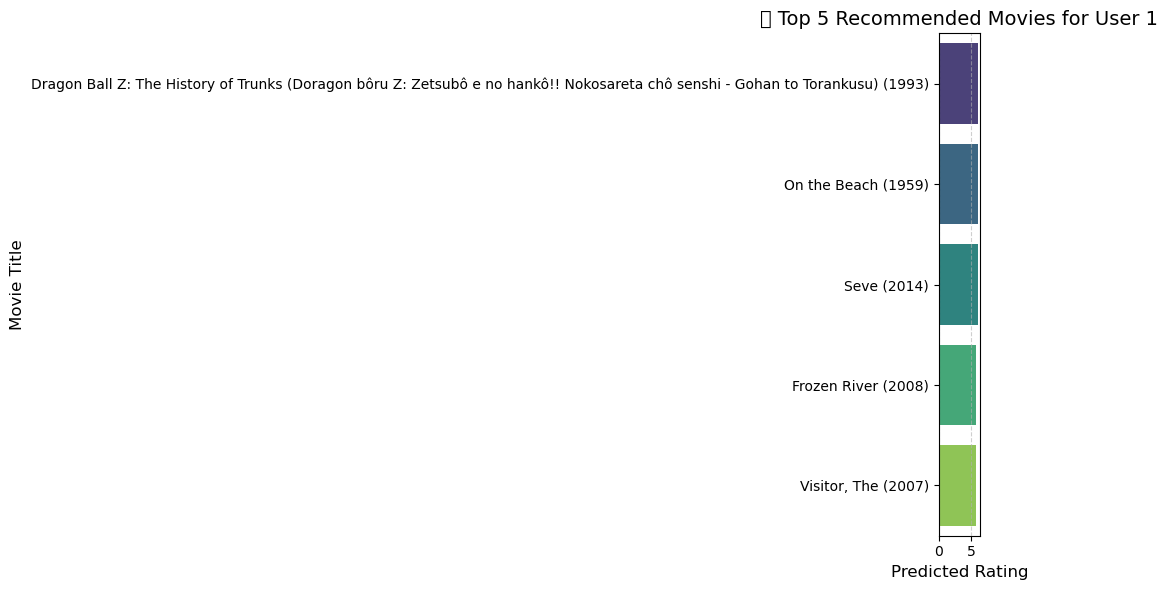

In [10]:
'''
Visualizating top recommendations for a user with movie titles
'''


# Generate user recommendations (if not already done)
try:
    user_recs
except NameError:
    user_recs = model.recommendForAllUsers(5)

# Pick a user and extract their recommendations
user_id = 1
user_row = user_recs.filter(f"userId == {user_id}").select("recommendations").collect()

if user_row:
    # Extract recommendations (Spark Row objects) and convert to list of dicts
    user_recs_list = [rec.asDict() for rec in user_row[0]["recommendations"]]
    user_recs_pd = pd.DataFrame(user_recs_list)

    # Merge with movie titles for readability
    movies_pd = movies.toPandas()
    if "movieId" not in movies_pd.columns:
        raise KeyError("❌ The 'movies' DataFrame must contain a 'movieId' column.")
    
    user_recs_pd = user_recs_pd.merge(movies_pd, on="movieId", how="left")

    # Plot top recommended movie titles with predicted ratings
    plt.figure(figsize=(10, 6))
    sns.barplot(data=user_recs_pd, x="rating", y="title", palette="viridis")
    plt.title(f"🎬 Top 5 Recommended Movies for User {user_id}", fontsize=14)
    plt.xlabel("Predicted Rating", fontsize=12)
    plt.ylabel("Movie Title", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

else:
    print(f"⚠️ No recommendations found for user {user_id}.")


/tmp/ipykernel_902/3024292372.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=user_recs_pd, x="rating", y="title", palette="viridis")
/tmp/ipykernel_902/3024292372.py:26: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  plt.tight_layout()
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


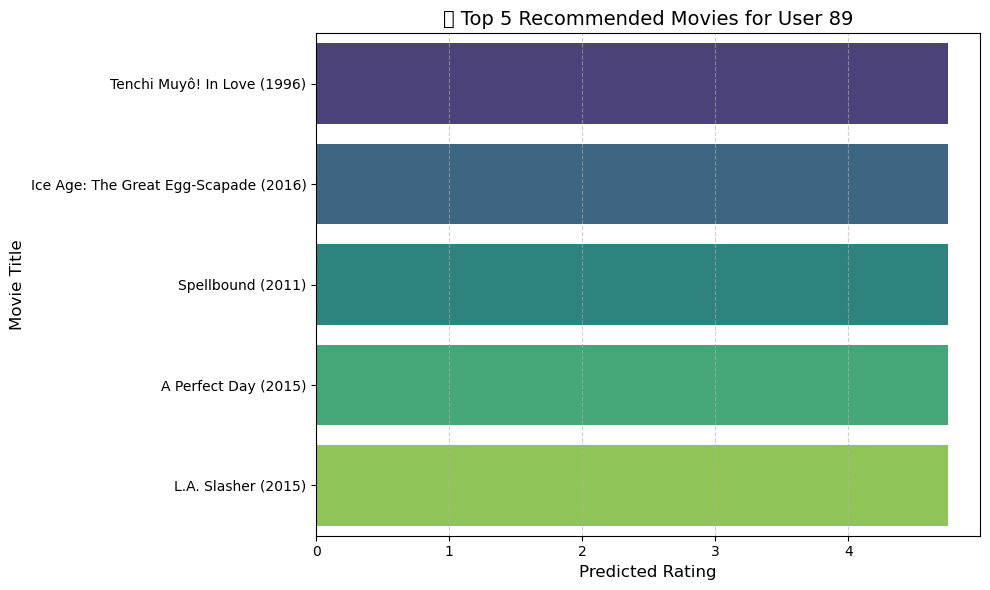

In [11]:
try:
    user_recs
except NameError:
    user_recs = model.recommendForAllUsers(5)

user_id = 89
user_row = user_recs.filter(f"userId == {user_id}").select("recommendations").collect()

if user_row:
    user_recs_list = [rec.asDict() for rec in user_row[0]["recommendations"]]
    user_recs_pd = pd.DataFrame(user_recs_list)

    movies_pd = movies.toPandas()
    if "movieId" not in movies_pd.columns:
        raise KeyError("❌ The 'movies' DataFrame must contain a 'movieId' column.")
    
    user_recs_pd = user_recs_pd.merge(movies_pd, on="movieId", how="left")

    # Plot top recommended movie titles 
    plt.figure(figsize=(10, 6))
    sns.barplot(data=user_recs_pd, x="rating", y="title", palette="viridis")
    plt.title(f"🎬 Top 5 Recommended Movies for User {user_id}", fontsize=14)
    plt.xlabel("Predicted Rating", fontsize=12)
    plt.ylabel("Movie Title", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

else:
    print(f"No recommendations found for user {user_id}.")